# Forecast S&P 500 Index Closing Price

The goal is to predict the closing price of the S&P 500 Index for the last 20% of the dataset using three RNN tuned models. The independent variables include the volume of trades, opening price, lowest price, and highest price for each day.

In [83]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import mean_absolute_error, mean_squared_error

## Ingest

In [110]:
data = pd.read_csv('https://raw.githubusercontent.com/jhancuch/SP500-forecasting/main/data/daily_index.csv')

In [111]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1-Mar-17,"2,380.13","2,400.98","2,380.13","2,395.96","2,395.96","4,345,180,000"
1,2-Mar-17,"2,394.75","2,394.75","2,380.17","2,381.92","2,381.92","3,821,320,000"
2,3-Mar-17,"2,380.92","2,383.89","2,375.39","2,383.12","2,383.12","3,555,260,000"
3,6-Mar-17,"2,375.23","2,378.80","2,367.98","2,375.31","2,375.31","3,232,700,000"
4,7-Mar-17,"2,370.74","2,375.12","2,365.51","2,368.39","2,368.39","3,518,390,000"


In [112]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1254,22-Feb-22,"4,332.74","4,362.12","4,267.11","4,304.76","4,304.76","4,007,780,000"
1255,23-Feb-22,"4,324.93","4,341.51","4,221.51","4,225.50","4,225.50","3,814,340,000"
1256,24-Feb-22,"4,155.77","4,294.73","4,114.65","4,288.70","4,288.70","5,070,560,000"
1257,25-Feb-22,"4,298.38","4,385.34","4,286.83","4,384.65","4,384.65","3,941,780,000"
1258,28-Feb-22,"4,354.17","4,388.84","4,315.12","4,373.94","4,373.94","4,594,010,000"


In [113]:
data.shape

(1259, 7)

In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       1259 non-null   object
 1   Open       1259 non-null   object
 2   High       1259 non-null   object
 3   Low        1259 non-null   object
 4   Close      1259 non-null   object
 5   Adj Close  1259 non-null   object
 6   Volume     1259 non-null   object
dtypes: object(7)
memory usage: 69.0+ KB


In [115]:
data['Date'] = pd.to_datetime(data['Date'])
data['Open'] = data['Open'].str.replace(',','').astype(float)
data['High'] = data['High'].str.replace(',','').astype(float)
data['Low'] = data['Low'].str.replace(',','').astype(float)
data['Close'] = data['Close'].str.replace(',','').astype(float)
data['Adj Close'] = data['Adj Close'].str.replace(',','').astype(float)
data['Volume'] = data['Volume'].str.replace(',','').astype(int)

In [116]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,3188.838793,3205.339841,3170.685044,3189.184885,3189.184885,3.867971e+09
std,688.961141,692.549064,685.400607,689.307955,689.307955,1.067455e+09
min,2290.710000,2300.730000,2191.860000,2237.400000,2237.400000,1.296540e+09
25%,2691.105000,2708.745000,2677.385000,2692.190000,2692.190000,3.233955e+09
50%,2918.460000,2931.150000,2903.820000,2919.370000,2919.370000,3.589930e+09
75%,3634.840000,3643.310000,3608.960000,3632.530000,3632.530000,4.155015e+09
max,4804.510000,4818.620000,4780.040000,4796.560000,4796.560000,9.878040e+09


I initially used volume in the model but there were wild swings in the predictions from day to day. Even though the data was scaled by the max value, the volume measure was so large it likely muted the explanitory effect of min, max, and opening prices. After dropping volume, I had much less swings in predictions day to day.

In [126]:
data.drop(columns=['Volume'], axis=1, inplace=True)

## EDA

The dataset is relatively clean. I had to do some type conversion at the ingestion stage to ensure the variables were numeric rather than string. I plot open and close and find that even though we hear about wild swings, the open and close track very closely. 

In [92]:
data.isnull().sum().sum()

0

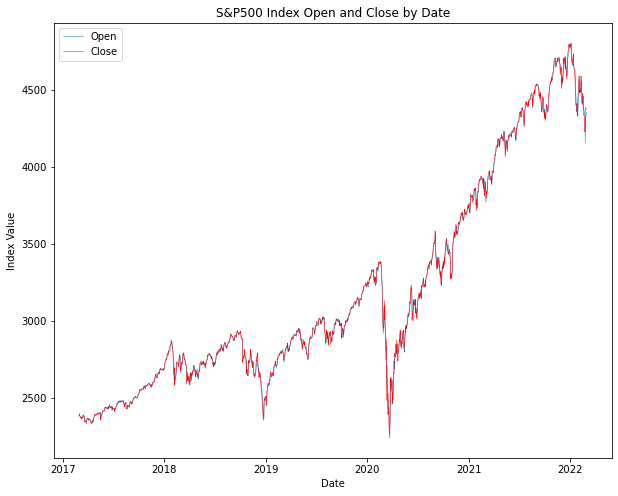

In [93]:
plt.figure(figsize=(10, 8))

plt.plot(data.Date, data.Open, label='Open', linewidth=.5)
plt.plot(data.Date, data.Close, color='red', label='Close', linewidth=.5)

#add title and axis labels
plt.title('S&P500 Index Open and Close by Date')
plt.xlabel('Date')
plt.ylabel('Index Value')

#add legend
plt.legend()

#display plot
plt.show() 

I have both close and adjusted close variables. To investigate if there are any differences, I plot them together and also subtract the two vectors from each other. Visually I don't see any differences and numerically I end up with a vectors of 0 indicating that close and adj close contain the same value for each day.

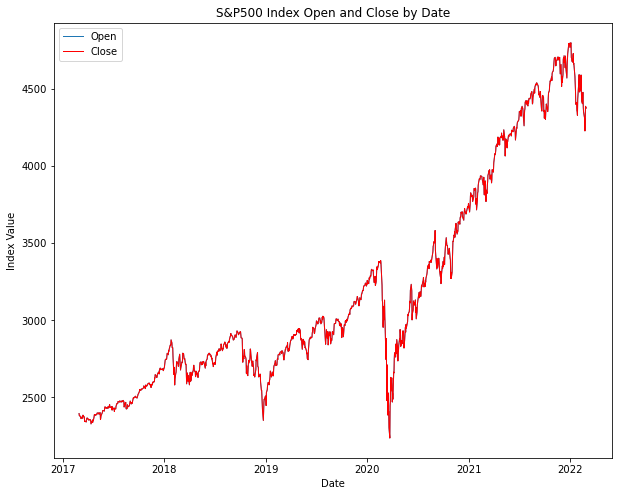

In [94]:
plt.figure(figsize=(10, 8))

plt.plot(data.Date, data['Adj Close'], label='Open', linewidth=1)
plt.plot(data.Date, data.Close, color='red', label='Close', linewidth=1)

#add title and axis labels
plt.title('S&P500 Index Open and Close by Date')
plt.xlabel('Date')
plt.ylabel('Index Value')

#add legend
plt.legend()

#display plot
plt.show() 

In [95]:
(data['Close'] - data['Adj Close'])

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1254    0.0
1255    0.0
1256    0.0
1257    0.0
1258    0.0
Length: 1259, dtype: float64

In [96]:
(data['Close'] - data['Adj Close']).max()

0.0

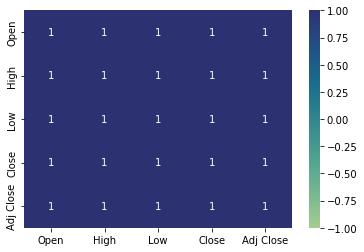

In [97]:
sns.heatmap(data.corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()

## Modeling

### Preprocessing

I first determine the entire length of the dataset and then determine at what integer is 80%. I use this marker to split the train and test set to ensure the training set and test set are in order rather than randomly split.

I also find the max value of the dataset and scale the values by such.

In [98]:
len(data)

1259

In [99]:
len(data)*.8

1007.2

In [127]:
data.iloc[:, 1:].max().max()

4818.62

In [128]:
X_train, y_train, X_test, y_test = data.iloc[:1008, 1:4]/4818.62, data.iloc[:1008, 4]/4818.62, data.iloc[1008:, 1:4]/4818.62, data.iloc[1008:, 4]/4818.62

In [129]:
X_train, X_test = np.array(X_train), np.array(X_test)

X_train_array = np.asarray(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])))
X_test_array = np.asarray(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]))
y_train_array = np.asarray(y_train) 
y_test_array = np.asarray(y_test)

### Model 1

For Model 1, I choose a multi-layered simple RNN with drop out layers of 20% to help with the unstable gradient with long forecasting series. I additionally incorporate a cut off of two straight epochs without an improvement in the training RMSE. 

The result is that I predict are close with a RMSE of 0.031 but are consistently too low.

In [157]:
model_1 = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True, input_shape=(1, X_train_array.shape[2])),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

In [158]:
callback = tf.keras.callbacks.EarlyStopping(monitor='root_mean_squared_error', patience=2)

In [159]:
model_1.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.RootMeanSquaredError()])

In [160]:
history_model_1 = model_1.fit(X_train_array, y_train_array, epochs=100, 
                              validation_data=(X_test_array, y_test_array), 
                              callbacks=[callback])

Epoch 1/100
32/32 [==============================] - 5s 60ms/step - loss: 0.0829 - root_mean_squared_error: 0.2798 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0968
Epoch 2/100
32/32 [==============================] - 1s 33ms/step - loss: 0.0141 - root_mean_squared_error: 0.1186 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1039
Epoch 3/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0096 - root_mean_squared_error: 0.0978 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0704
Epoch 4/100
32/32 [==============================] - 1s 28ms/step - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1241
Epoch 5/100
32/32 [==============================] - 1s 27ms/step - loss: 0.0055 - root_mean_squared_error: 0.0743 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1236
Epoch 6/100
32/32 [==============================] - 1s 29ms/step - loss: 0.0049 - root_mean_squared_error: 0.0700 - val_loss: 0.0111 - val_

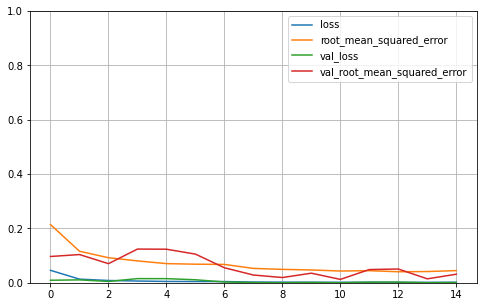

In [161]:
pd.DataFrame(history_model_1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [166]:
model_1_forecast = model_1.predict(X_test_array).reshape(-1,)

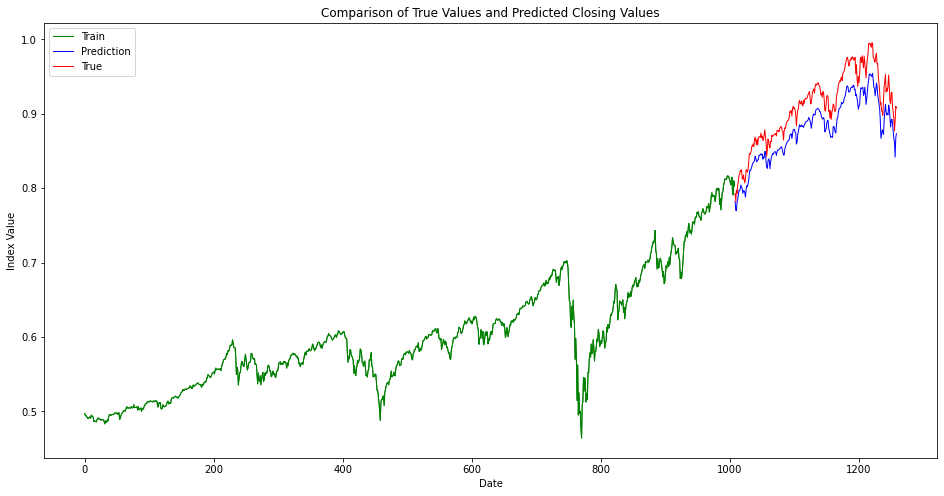

In [168]:
plt.figure(figsize=(16, 8))

train_x_axis = range(0, len(X_train_array))
pred_x_axis = range(max(train_x_axis) + 1, len(model_1_forecast) + max(train_x_axis) + 1)
                 
plt.plot(train_x_axis, y_train_array, color = 'green', linewidth=1)
plt.plot(train_x_axis, y_train_array, color='green', label='Train', linewidth=1)
plt.plot(pred_x_axis, model_1_forecast, color = 'blue', label='Prediction', linewidth=1)
plt.plot(pred_x_axis, y_test_array, color='red', label='True', linewidth=1)

#add title and axis labels
plt.title('Comparison of True Values and Predicted Closing Values')
plt.xlabel('Date')
plt.ylabel('Index Value')

#add legend
plt.legend()

#display plot
plt.show() 

In [169]:
np.sqrt(mean_squared_error(y_test_array, model_1_forecast))

0.031610909866022975

### Model 2

For Model 2, I use GRUs and incorporate every other dropout layers to help with the unstable gradient of long forecasting series. This model performs a bit better with a RMSE of ..19 but I consistently predict too low of values. This halves the previous RMSE though of Model 1.

In [170]:
model_2 = keras.models.Sequential([
    keras.layers.GRU(50, return_sequences=True, input_shape=(1, X_train_array.shape[2])),
    keras.layers.GRU(50, return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.GRU(50, return_sequences=True),
    keras.layers.GRU(50, return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.GRU(50, return_sequences=True),
    keras.layers.GRU(50, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

In [171]:
callback = tf.keras.callbacks.EarlyStopping(monitor='root_mean_squared_error', patience=2)

In [172]:
model_2.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.RootMeanSquaredError()])

In [173]:
history_model_2 = model_2.fit(X_train_array, y_train_array, epochs=100, 
                              validation_data=(X_test_array, y_test_array),
                              callbacks=[callback])

Epoch 1/100
32/32 [==============================] - 16s 148ms/step - loss: 0.2358 - root_mean_squared_error: 0.4792 - val_loss: 0.0956 - val_root_mean_squared_error: 0.3092
Epoch 2/100
32/32 [==============================] - 1s 41ms/step - loss: 0.0082 - root_mean_squared_error: 0.0904 - val_loss: 0.0777 - val_root_mean_squared_error: 0.2787
Epoch 3/100
32/32 [==============================] - 1s 45ms/step - loss: 0.0055 - root_mean_squared_error: 0.0742 - val_loss: 0.0626 - val_root_mean_squared_error: 0.2502
Epoch 4/100
32/32 [==============================] - 1s 35ms/step - loss: 0.0049 - root_mean_squared_error: 0.0700 - val_loss: 0.0620 - val_root_mean_squared_error: 0.2490
Epoch 5/100
32/32 [==============================] - 1s 39ms/step - loss: 0.0046 - root_mean_squared_error: 0.0679 - val_loss: 0.0651 - val_root_mean_squared_error: 0.2552
Epoch 6/100
32/32 [==============================] - 1s 38ms/step - loss: 0.0042 - root_mean_squared_error: 0.0646 - val_loss: 0.0454 - va

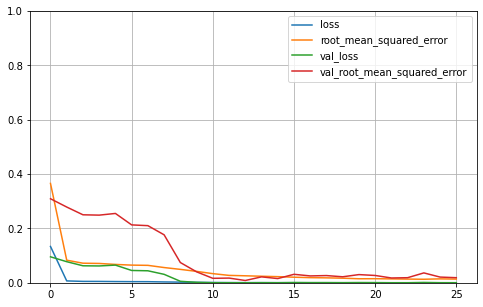

In [174]:
pd.DataFrame(history_model_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [177]:
model_2_forecast = model_2.predict(X_test_array).reshape(-1,)

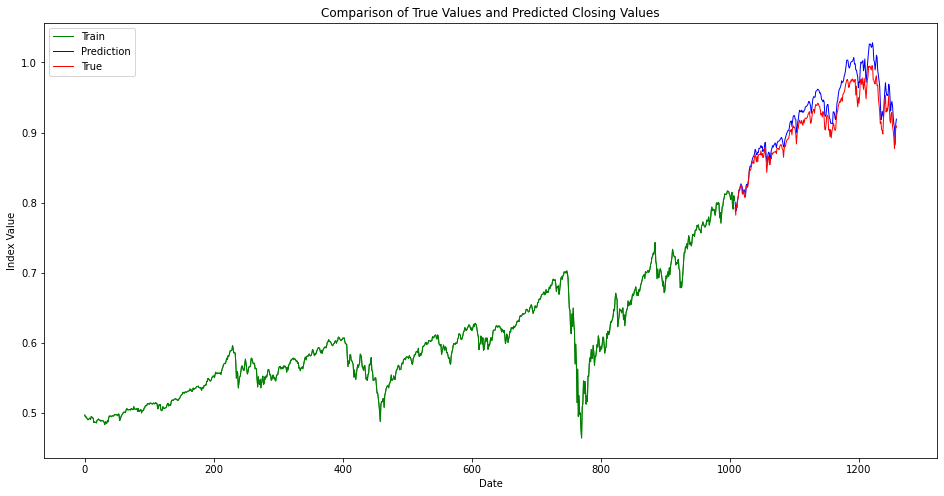

In [178]:
plt.figure(figsize=(16, 8))

train_x_axis = range(0, len(X_train_array))
pred_x_axis = range(max(train_x_axis) + 1, len(model_1_forecast) + max(train_x_axis) + 1)
                 
plt.plot(train_x_axis, y_train_array, color = 'green', linewidth=1)
plt.plot(train_x_axis, y_train_array, color='green', label='Train', linewidth=1)
plt.plot(pred_x_axis, model_2_forecast, color = 'blue', label='Prediction', linewidth=1)
plt.plot(pred_x_axis, y_test_array, color='red', label='True', linewidth=1)

#add title and axis labels
plt.title('Comparison of True Values and Predicted Closing Values')
plt.xlabel('Date')
plt.ylabel('Index Value')

#add legend
plt.legend()

#display plot
plt.show() 

In [179]:
np.sqrt(mean_squared_error(y_test_array, model_2_forecast))

0.01878598938891654

### Model 3

For Model 3, I implimented a version of WaveNet that utilizes stacked 1D convolutional layers that allows the lower layers to learn short-term patterns and higher layers to learn long-term patterns. The model is an improvement over Model 1 and Model 2 as the RMSE is 0.008. This is a drastic improvement from model 2.



In [180]:
model_3 = keras.models.Sequential()
model_3.add(keras.layers.InputLayer(input_shape=(1, X_train_array.shape[2])))
for rate in (1, 2, 4, 8) * 2:
    model_3.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model_3.add(keras.layers.Conv1D(filters=1, kernel_size=1))

In [181]:
model_3.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.RootMeanSquaredError()])

In [182]:
callback = tf.keras.callbacks.EarlyStopping(monitor='root_mean_squared_error', patience=1)

In [183]:
history_model_3 = model_3.fit(X_train_array, y_train_array, epochs=100, 
                              validation_data=(X_test_array, y_test_array),
                              callbacks=[callback])

Epoch 1/100
32/32 [==============================] - 9s 252ms/step - loss: 0.3165 - root_mean_squared_error: 0.5615 - val_loss: 0.2741 - val_root_mean_squared_error: 0.5236
Epoch 2/100
32/32 [==============================] - 9s 287ms/step - loss: 0.0245 - root_mean_squared_error: 0.1525 - val_loss: 0.0833 - val_root_mean_squared_error: 0.2886
Epoch 3/100
32/32 [==============================] - 8s 252ms/step - loss: 0.0045 - root_mean_squared_error: 0.0669 - val_loss: 0.0548 - val_root_mean_squared_error: 0.2341
Epoch 4/100
32/32 [==============================] - 10s 305ms/step - loss: 0.0035 - root_mean_squared_error: 0.0587 - val_loss: 0.0532 - val_root_mean_squared_error: 0.2307
Epoch 5/100
32/32 [==============================] - 1s 35ms/step - loss: 0.0033 - root_mean_squared_error: 0.0578 - val_loss: 0.0467 - val_root_mean_squared_error: 0.2161
Epoch 6/100
32/32 [==============================] - 7s 214ms/step - loss: 0.0029 - root_mean_squared_error: 0.0537 - val_loss: 0.0415 

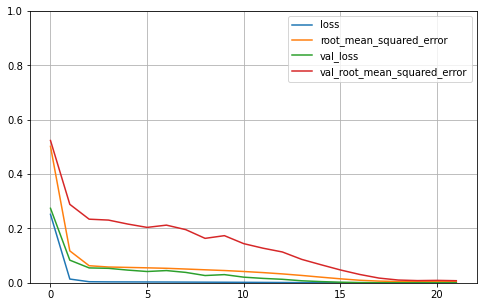

In [184]:
pd.DataFrame(history_model_3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [185]:
model_3_forecast = model_3.predict(X_test_array).reshape(-2,)

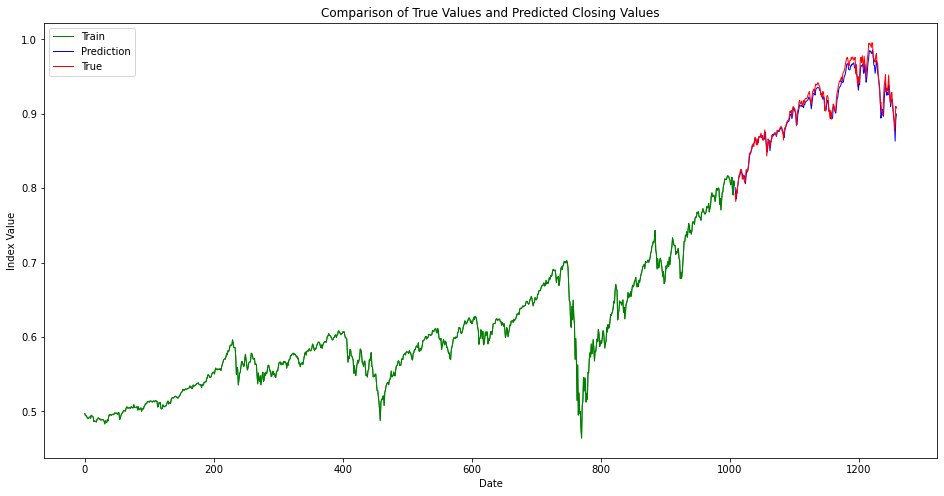

In [186]:
plt.figure(figsize=(16, 8))

train_x_axis = range(0, len(X_train_array))
pred_x_axis = range(max(train_x_axis) + 1, len(model_1_forecast) + max(train_x_axis) + 1)
                 
plt.plot(train_x_axis, y_train_array, color = 'green', linewidth=1)
plt.plot(train_x_axis, y_train_array, color='green', label='Train', linewidth=1)
plt.plot(pred_x_axis, model_3_forecast, color = 'blue', label='Prediction', linewidth=1)
plt.plot(pred_x_axis, y_test_array, color='red', label='True', linewidth=1)

#add title and axis labels
plt.title('Comparison of True Values and Predicted Closing Values')
plt.xlabel('Date')
plt.ylabel('Index Value')

#add legend
plt.legend()

#display plot
plt.show() 

In [187]:
np.sqrt(mean_squared_error(y_test_array, model_3_forecast))

0.007699116478970067

## Conclusion

Attempting to predict the close of the S&P 500 would be near impossible if I did not have the opening price, max price, and close price. Otherwise I have a feeling my predictions wouldn't have been close since if predicting the movement of stock indexes was possible, everyone would be doing it.

I find that the wavelength model performed the best by far with GRU a distant second and SimpleRNN a far third. The unique ability of the WaveLength algorithmic structure to be able to focus on both short term and long term trends likely helped generate a very close prediction to the truth.

### Results Table
| Metric | Model 1 | Model 2 | Model 3 |
|---     | ---     | ---     | ---     |
| Train RMSE | 0.042 | 0.014 | 0.005 | 
| Test RMSE | 0.031 | 0.019 | 0.008 |